In [1]:
# Importing the necessary libraries
import torch
from torch import optim, utils, tensor, nn

import matplotlib.pyplot as plt
from getdist import plots, MCSamples

from Network import Generator, Discriminator
from Signal_Generator import *

from tqdm import tqdm

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Defining the hyperparameters
datasize = 16000
num_sources = 1
noise_amplitude = 0
freq_range = (1e-4, 1e-1)
total_time = 1000

num_latent_variables = 20
learning_rate = 1e-5
weight_clip = 0.1

d_loss_threshold = -0.1
g_loss_threshold = -0.3
threshold_adjustment = 0.025
max_steps = 300

num_epochs = 2000

In [3]:
# Defining the distribution for amplitude and angular frequency
def amp_distribution(size):
    """
    Amplitude distribution using uniform distribution.
    """
    return np.random.uniform(4, 16, size=size)

def omega_distribution(size):
    """
    Angular frequency distribution using uniform distribution.
    """
    return np.random.uniform(2 * np.pi * 1e-4, 2 * np.pi * 1e-1, size=size)

In [4]:
# Creating the dataset
dataset = []

for i in range(datasize):
    SG = Signal_Generator(num_sources=num_sources, noise_amplitude=noise_amplitude, amp_distribution_func=amp_distribution, omega_distribution_func=omega_distribution, freq_range=freq_range, total_time=total_time)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [5]:
# Defining the WGAN traning class
class WGAN(nn.Module):
    def __init__(self, num_latent_variables, lr, weight_clip):
        super(WGAN, self).__init__()
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

In [6]:
""" # Test training
wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)

loss_list = []

for i in tqdm(range(100)):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend() """

' # Test training\nwgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)\n\nloss_list = []\n\nfor i in tqdm(range(100)):\n    for _, (signal_tensor, params_tensor) in enumerate(train_loader):\n        z = torch.randn(1, num_latent_variables, 1).to(device)\n        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)\n        loss_list.append(loss)\n    #print(f"Epoch {i}, Discriminator loss: {d_loss}")\n\nplt.plot(loss_list, label=[\'Generator Loss\', \'Discriminator Loss\'])\nplt.legend() '

In [7]:
""" wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)

loss_list = []

for i in tqdm(range(50)):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

for i in tqdm(range(50)):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend() """

' wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)\n\nloss_list = []\n\nfor i in tqdm(range(50)):\n    for _, (signal_tensor, params_tensor) in enumerate(train_loader):\n        z = torch.randn(1, num_latent_variables, 1).to(device)\n        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)\n        loss_list.append(loss)\n    #print(f"Epoch {i}, Discriminator loss: {d_loss}")\n\nfor i in tqdm(range(50)):\n    for _, (signal_tensor, params_tensor) in enumerate(train_loader):\n        z = torch.randn(1, num_latent_variables, 1).to(device)\n        loss = wgan.train_generator(signal_tensor, params_tensor, z)\n        loss_list.append(loss)\n    #print(f"Epoch {i}, Discriminator loss: {d_loss}")\n\nplt.plot(loss_list, label=[\'Generator Loss\', \'Discriminator Loss\'])\nplt.legend() '

In [8]:
# Adaptive training
wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)

loss_list = []

ncri_list = []
ngen_list = []

d_loss_threshold = -0.1
g_loss_threshold = -0.3

training_d = True

for epoch in tqdm(range(num_epochs)):
    ncri = 0
    ngen = 0
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        critic_steps = 0
        generator_steps = 0
        
        while training_d and critic_steps < max_steps:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ncri+=1
            critic_steps+=1
            if loss[0] > g_loss_threshold:
                training_d = False
                break

        if critic_steps == max_steps:
            g_loss_threshold -= threshold_adjustment

        while not training_d and generator_steps < max_steps:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ngen+=1
            generator_steps+=1
            if loss[1] > d_loss_threshold:
                training_d = True
                break

        if generator_steps == max_steps:
            d_loss_threshold -= threshold_adjustment

    ncri_list.append(ncri)
    ngen_list.append(ngen)

100%|██████████| 2000/2000 [5:09:24<00:00,  9.28s/it]  


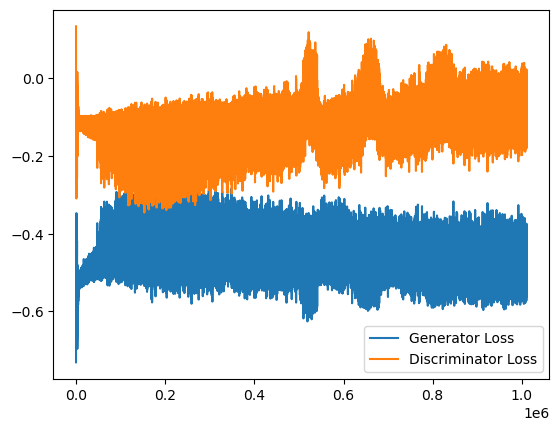

In [9]:
plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend()

In [10]:
""" training_d = True

for epoch in tqdm(range(500)):
    ncri = 0
    ngen = 0
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        critic_steps = 0
        generator_steps = 0
        
        while training_d and critic_steps < max_steps:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ncri+=1
            critic_steps+=1
            if loss[0] > g_loss_threshold:
                training_d = False
                break

        if critic_steps == max_steps:
            g_loss_threshold -= threshold_adjustment

        while not training_d and generator_steps < max_steps:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ngen+=1
            generator_steps+=1
            if loss[1] > d_loss_threshold:
                training_d = True
                break

        if generator_steps == max_steps:
            d_loss_threshold -= threshold_adjustment

    ncri_list.append(ncri)
    ngen_list.append(ngen) """

' training_d = True\n\nfor epoch in tqdm(range(500)):\n    ncri = 0\n    ngen = 0\n    for _, (signal_tensor, params_tensor) in enumerate(train_loader):\n        z = torch.randn(1, num_latent_variables, 1).to(device)\n\n        critic_steps = 0\n        generator_steps = 0\n        \n        while training_d and critic_steps < max_steps:\n            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)\n            loss_list.append(loss)\n            ncri+=1\n            critic_steps+=1\n            if loss[0] > g_loss_threshold:\n                training_d = False\n                break\n\n        if critic_steps == max_steps:\n            g_loss_threshold -= threshold_adjustment\n\n        while not training_d and generator_steps < max_steps:\n            loss = wgan.train_generator(signal_tensor, params_tensor, z)\n            loss_list.append(loss)\n            ngen+=1\n            generator_steps+=1\n            if loss[1] > d_loss_threshold:\n                training_

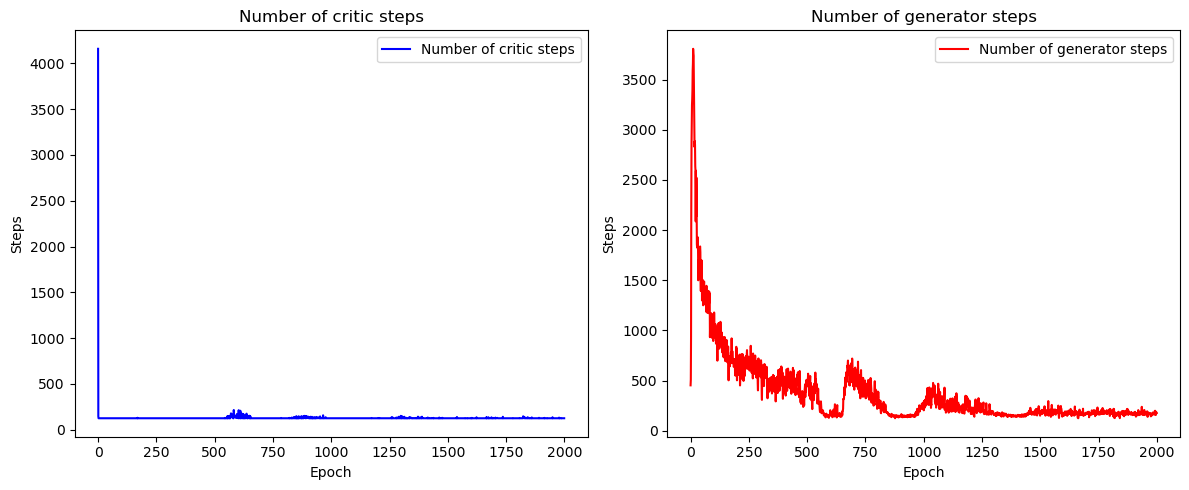

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(ncri_list, label='Number of critic steps', color='blue')
axs[0].set_title('Number of critic steps')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Steps')
axs[0].legend()

axs[1].plot(ngen_list, label='Number of generator steps', color='red')
axs[1].set_title('Number of generator steps')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Steps')
axs[1].legend()

plt.tight_layout()

In [12]:
generator = wgan.generator
discriminator = wgan.discriminator

generator.eval()

Generator(
  (init_conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (init_relu): LeakyReLU(negative_slope=0.2)
  (res_block_no_norm): ResBlock(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down1): Conditional_Down(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): LeakyReLU(negative_slope=0.2)
    (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (res_block): Conditional_ResBlock(
      (conv1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (process1): CIN(
        (inst_norm): InstanceNorm1d(

[7.5564281194917164, 2.338999858179122, 2.9109582046335616]
[array([7.36715  , 2.3082826, 2.948516 ], dtype=float32), array([7.347527 , 2.235428 , 2.8047802], dtype=float32), array([7.647041 , 2.3186743, 3.042386 ], dtype=float32), array([7.4847984, 2.2869527, 2.874737 ], dtype=float32), array([7.575568 , 2.2726655, 2.8852794], dtype=float32), array([7.351649 , 2.2797782, 2.95469  ], dtype=float32), array([7.3511395, 2.3804488, 2.9257293], dtype=float32), array([7.404379 , 2.3057723, 2.9143147], dtype=float32), array([7.513623 , 2.3933678, 2.8624368], dtype=float32), array([7.417702 , 2.375614 , 2.8629298], dtype=float32), array([7.310597 , 2.2513902, 2.7774653], dtype=float32), array([7.332415 , 2.3330662, 2.8451085], dtype=float32), array([7.4187436, 2.4013562, 2.8386102], dtype=float32), array([7.6623287, 2.3619232, 2.9312892], dtype=float32), array([7.4278884, 2.3136733, 2.7722747], dtype=float32), array([7.4288692, 2.2082458, 2.760331 ], dtype=float32), array([7.354506 , 2.3404653

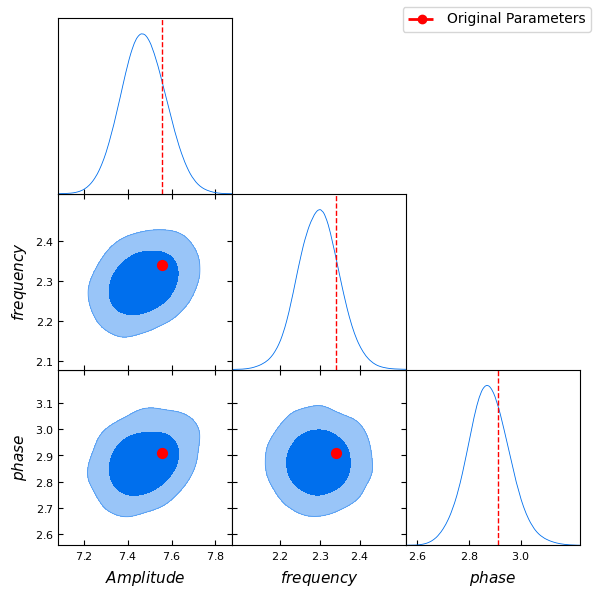

In [13]:
generated_params_list = []

TS = Signal_Generator(num_sources=num_sources, noise_amplitude=noise_amplitude, freq_range=freq_range, total_time=total_time)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

print(params)
print(generated_params_list)

generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])

names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels, settings={'ignore_rows': 1000})
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()

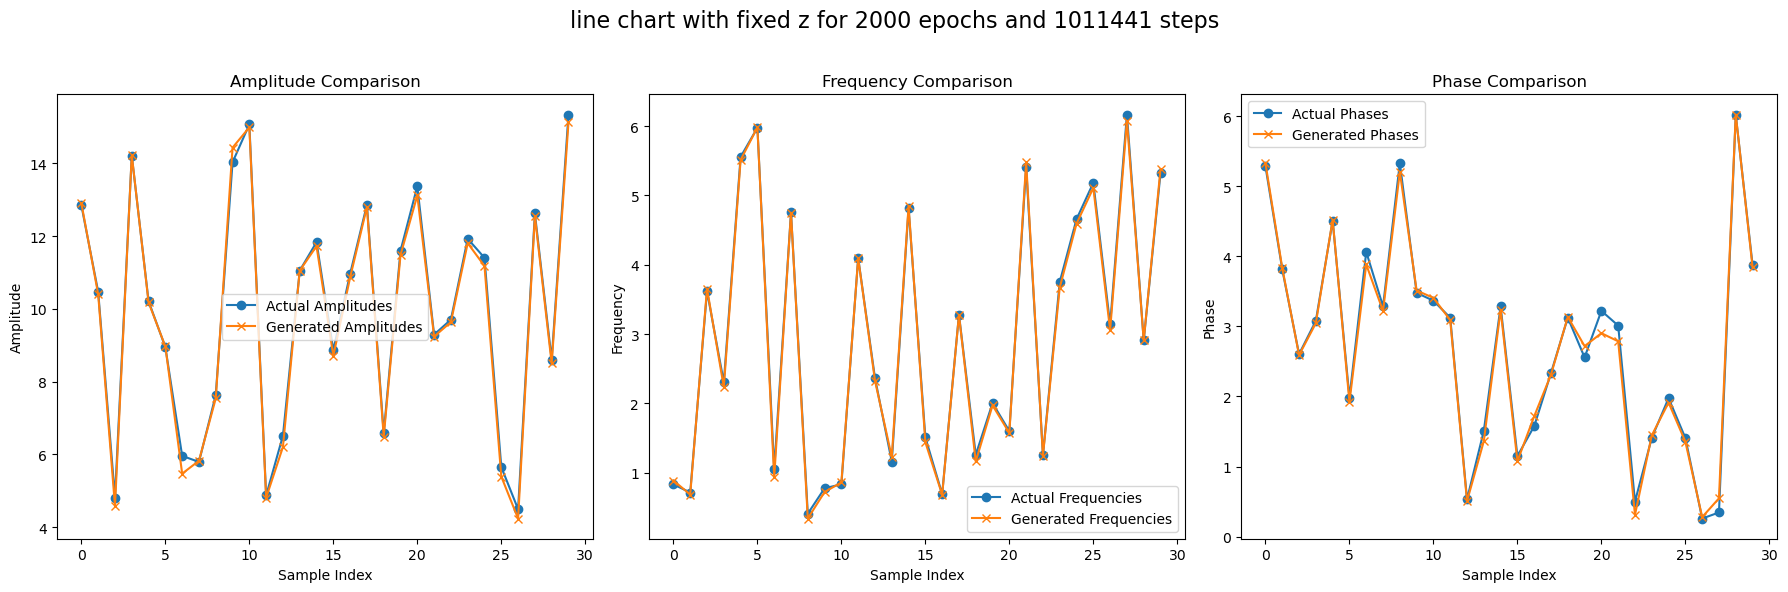

In [17]:
params_list = []
generated_params_list = []

test_times = 30
for i in range(test_times):
    TS = Signal_Generator(num_sources=num_sources, noise_amplitude=noise_amplitude, amp_distribution_func=amp_distribution
                          , omega_distribution_func=omega_distribution, freq_range=freq_range, total_time=total_time)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    #print(params)
    #print(generated_params)

actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.suptitle(f'line chart with fixed z for {num_epochs} epochs and {len(loss_list)} steps', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

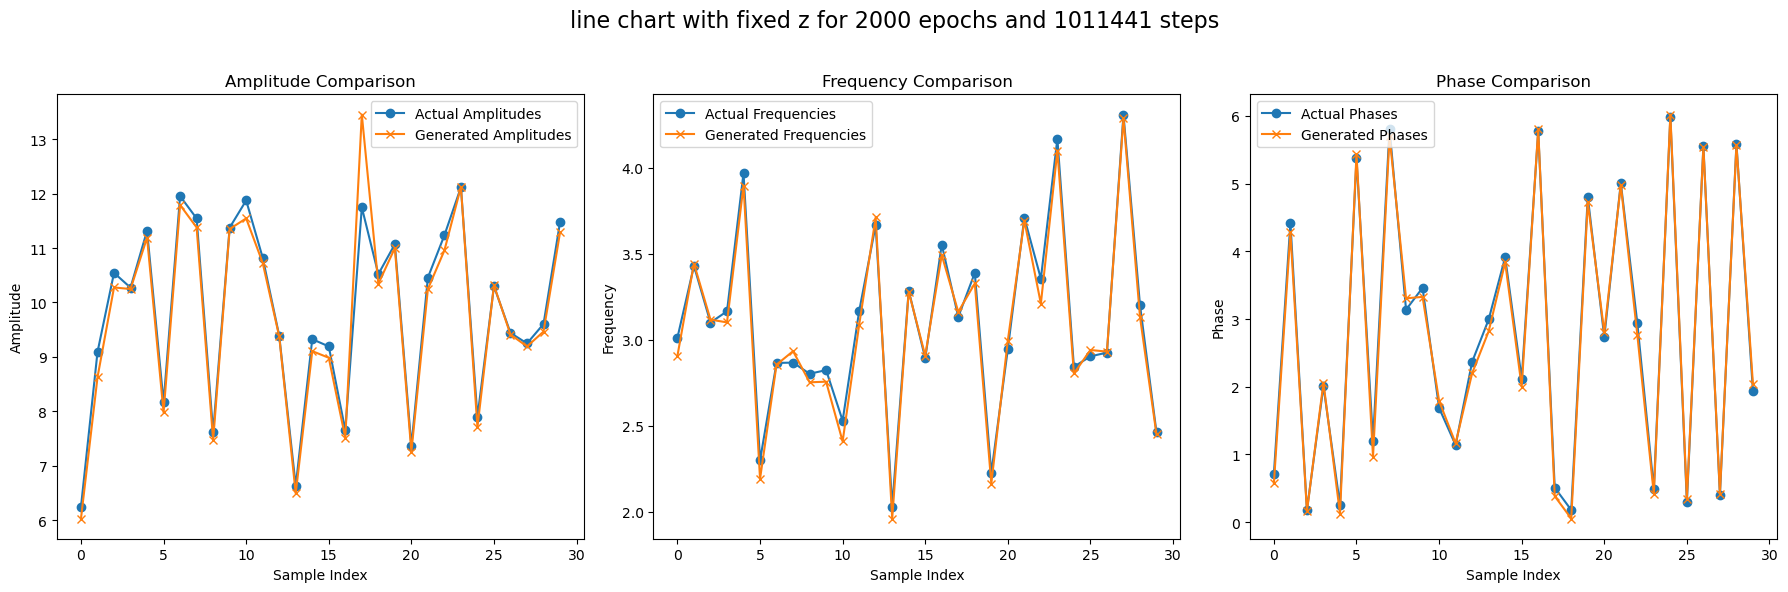

In [15]:
params_list = []
generated_params_list = []

test_times = 30
for i in range(test_times):
    TS = Signal_Generator(num_sources=num_sources, noise_amplitude=noise_amplitude, freq_range=freq_range, total_time=total_time)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    #print(params)
    #print(generated_params)

actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.suptitle(f'line chart with fixed z for {num_epochs} epochs and {len(loss_list)} steps', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
""" torch.save(generator, 'generator_2000nor.pt')
torch.save(discriminator, 'discriminator_2000nor.pt') """

" torch.save(generator, 'generator_2000nor.pt')\ntorch.save(discriminator, 'discriminator_2000nor.pt') "